In [3]:
import os
import time
import uuid
import cv2

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [13]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
images = tf.data.Dataset.list_files(os.path.join("data", "images", "*.jpg"), shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\410aa5c9-a941-11ee-bfa0-141333dfd063.jpg'

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [211, 218, 228],
        [211, 218, 228],
        [211, 218, 228]],

       [[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [210, 217, 227],
        [210, 217, 227],
        [210, 217, 227]],

       [[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [210, 217, 227],
        [209, 216, 226],
        [209, 216, 226]],

       ...,

       [[147, 147, 155],
        [146, 146, 156],
        [134, 134, 146],
        ...,
        [ 49,  44,  66],
        [ 49,  44,  66],
        [ 49,  44,  66]],

       [[145, 145, 153],
        [144, 144, 154],
        [131, 133, 145],
        ...,
        [ 49,  44,  64],
        [ 49,  45,  62],
        [ 49,  45,  62]],

       [[143, 143, 151],
        [141, 141, 151],
        [129, 131, 143],
        ...,
        [ 49,  45,  62],
        [ 49,  45,  62],
        [ 49,  45,  60]]

In [9]:
len(images)

90

View Raw images with matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

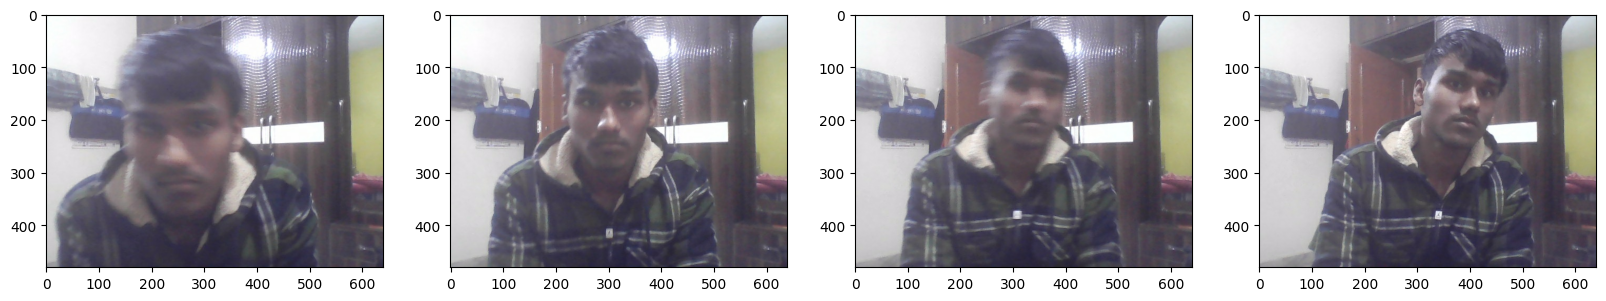

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

data partition into train, test, and validation

In [18]:
from sklearn.model_selection import train_test_split
import shutil

In [21]:
source_folder = "data/images"
train_folder = "data/train/images"
test_folder = "data/test/images"
val_folder = "data/val/images"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

all_images = os.listdir(source_folder)

In [22]:
train_images, test_images = train_test_split(all_images, test_size=0.3, random_state=42)
test_images, val_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [23]:
for img in train_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(train_folder, img))

for img in test_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(test_folder, img))

for img in val_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(val_folder, img))

Map the data with respective labels

In [24]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [27]:
img = cv2.imread(os.path.join('data', 'train', 'images', '4a21d1ec-a941-11ee-a597-141333dfd063.jpg'))

In [28]:
img.shape

(480, 640, 3)

In [29]:
img

array([[[237, 229, 230],
        [236, 228, 229],
        [233, 228, 227],
        ...,
        [195, 190, 189],
        [194, 189, 188],
        [193, 188, 187]],

       [[236, 228, 229],
        [236, 228, 229],
        [233, 228, 227],
        ...,
        [195, 190, 189],
        [193, 188, 187],
        [192, 187, 186]],

       [[234, 228, 229],
        [233, 227, 228],
        [233, 228, 227],
        ...,
        [196, 189, 186],
        [195, 187, 187],
        [194, 186, 186]],

       ...,

       [[100,  96, 101],
        [ 99,  95, 100],
        [101,  95, 100],
        ...,
        [ 59,  36,  41],
        [ 60,  37,  42],
        [ 60,  37,  42]],

       [[101,  97, 102],
        [100,  96, 101],
        [102,  96, 101],
        ...,
        [ 60,  37,  42],
        [ 62,  36,  42],
        [ 62,  36,  42]],

       [[101,  97, 102],
        [100,  96, 101],
        [101,  95, 100],
        ...,
        [ 60,  37,  42],
        [ 62,  36,  42],
        [ 63,  37,  43]]

Apply augmentation on images and labels using albumentations

In [25]:
import albumentations as alb

In [26]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2), 
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels'])
                        )